In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# Population Dynamics functions

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

'''
rungekutta method
for solving diffeq system

I don't think this should work
'''

def rungeKutta(func, pos,Δt, params):
    #pos = [q,N,n,x]
    pos = np.array(pos)  
    # rest of rungekutta
    k1 = func(pos, params)
    k2 = func(pos + (Δt/2)*k1, params )
    k3 = func(pos + (Δt/2)*k2, params )
    k4 = func(pos + Δt * k3, params )
    pos_final = pos + (Δt/6) * (k1 + 2*k2 + 2*k3 + k4)
    return pos_final
'''
Model functions
calles the differential equations
pos = m,M,x,p
params = a dictionary of parameters non-dimensionalized
    dict(η1, η2, κ1, κ2, preygrowth,
    A_0, a_0,  θ1, θ2, fun_response_type,
    c_1, c_2, 
    v, r, γ, δ, joining_rule, x_timescale) 
    where prey growth == "linear" or "logistic"
    fun_response_type = 1 (linear) or 2 (Holling's type II)
    joining_rule = "free" or "groups_decide"
    x_timescale = "fast" or "slow"
    δ is death-rate, which is from the full parameter set. need it to calculate p = δq, 
        the predator population size, which is the upper limit on group size
'''
def model(pos, x_timescale, params):
    dqdτ = fun_dpdt(*pos,**params)
    dNdτ = fun_dMdt(*pos,**params)
    dndτ = fun_dmdt(*pos,**params)
    if x_timescale == "slow":
        dxdτ = fun_dxdt(*pos,**params)
    elif x_timescale == "fast":
        dxdτ = 0
    return np.array([dqdτ, dndτ, dNdτ, dxdτ])
    
'''
fun_dNdτ: dynamics of big prey, non-dimensionalized
'''
def fun_dNdτ(q,N,n,x,**params):
    
    def fun_growth_big(N,η1,κ1, preygrowth, **params):
        if preygrowth == "logistic":
            return η1*N*(1 - N/κ1)
        elif preygrowth == "linear":
            return η1*N
        
    return fun_growth_big(n,**params) - q*fun_response_big(N,n,x,**params)/x
'''
fun_dndτ: dynamics of small prey, non-dimensionalized
'''
def fun_dndτ(q,N,n,x,**params):
    
    def fun_growth_small(n,η2,κ2, preygrowth, **params):
        if preygrowth == "logistic":
            return η2*n*(1 - n/κ2)
        elif preygrowth == "linear":
            return η2*n
        
    return fun_growth_small(n,**params) - q*fun_response_small(N,n,x,**params)/x



'''
fun_dpdt: dynamics of predator population, non-dimensionalized
requires parameters c1, c2 (benefit conversions of big prey and small prey) and, 
    for the functional responses, a_0, A_0, θ1, θ2, and fun_response_type
'''
def fun_dqdτ(q, N, n, x, c1, c2, **params):
    
    return q*((c1/x)*fun_response_big(N,n,x,**params)\
              + (c2/x)*fun_response_small(N,n,x,**params) - 1)


'''
fun_dxdt: dynamics of cooperation

this works for $x \geq 2$


parameter v is the rate of evolution
joining_rule = "free" (can freely leave or join) or "group_decide" (subordinates allow an individual 
to join if it increases subordinates' fitness)
'''
def fun_dxdt(q,N,n,x,v, joining_rule, **params):
    if joining_rule == "free":
        return v*(fitness_group_sub(n, N, x,**params) \
                  - per_capita_fitness(n,N,1,**params)) 
    elif joining_rule == "group_decides":
        return v*diff_fitness_group(n,N,x,**params)
    return 1
    
                
'''
Iterate from x= 1 until the equilibrium group size
Need predator population size p for this, where q = p/δ
'''                
def fun_iterate_x(q,N,n,joining_rule,δ, **params):
    
    W_of_1 = per_capita_fitness(n, N, x, **params)
    p = q*δ # the upper limit on group size
    
    # no groups if no predators, only group size is 1 if 1 predator
    if p == 0:
        return 0
    elif p == 1:
        return 1
    
    x = 1
    
    # growth of groups
    if joining_rule == "free":
        for i in range(2,p):
            W_of_i = fitness_group_sub(n,N,i,**params)
            if W_of_i > W_of_1:
                x = i
            else:
                return i
    elif joining_rule == "group_decides":
        W_of_x = W_of_1
        for i in range(2,p):
            W_of_i = fitness_group_sub(n,N,i,**params)
            if W_of_i > W_of_x:
                x = i
                W_of_x = W_of_i
            else:
                return x
    # if you get out of the previous for loops without 
    # reaching a point where W_of_i < W_of_x or W_of_1, then x^* = p
    
    return p
    

In [8]:
# Equilibrium Functions

def fun_get_x_equilibrium(n,N,x,**params):
    return 1

In [7]:
# Population Dynamics helper functions

'''
predator functional response to big prey
using non-dimensionalized parameters
fun_response_type indicates whether type I or type II functional response
'''
def fun_response_big(n,N,x,A_0, a_0,θ1, θ2, fun_response_type, **params):
    a = a_0*x**θ2
    A = A_0*x**θ1
    if fun_response_type == 1:
        return A*N
    elif fun_response_type == 2:
        return A*N / (1 + a*n + A*N)
    
'''
predator functional response to small prey
using non-dimensionalized parameters
fun_response_type indicates whether type I or type II functional response
'''
def fun_response_small(n, N, x, A_0, a_0, θ1, θ2, fun_response_type, **params):
    a = a_0*x**θ2
    A = A_0*x**θ1
    if fun_response_type == 1:
        return a*n
    elif fun_response_type == 2:
        return a*n / (1 + a*n + A*N)

    
'''
The non-dimensionalized per-capita-fitness of a predator
this is equal to δ*\bar{w}
'''
def per_capita_fitness(n, N, x, c1, c2, **params):
    f = fun_response_small(n,N,x,**params)
    F = fun_response_big(n,N,x,**params)
    return (c1/x)*F + (c2/x)*F

'''
The non-dimensionalized fitness of a subordinate predator in a group
'''
def fitness_group_sub(n, N, x, r, γ,**params):
    return per_capita_fitness(n, N, x, **params)*((1-γ)*(1-r) + r*x)

'''
The non-dimensionalized derivative of the fitness of a subordinate predator in a group 
wrt group size, x
'''
def diff_fitness_group(n, N, x, A_0, a_0, θ1, θ2, 
                       fun_response_type, c1, c2, r, γ, **params):
    R = (1-r)*(1-γ)
    α1 = N*A_0*x**θ1
    α2 = n*a_0*x**θ2
    ω1 = c1*α1
    ω2 = c2*α2
    
    if fun_response_type ==2:
        G_of_x = (ω1*x**θ1 + ω2*x**θ2)(rx*(1+α1*x**θ1 + α2*x**θ2) - \
                                       (R + r*x)*(α1*θ1*x**θ1 + α2*θ2*x**θ2)) \
        + (R+r*x)*(1 + α1*x**θ1 + α2*x**θ2)*(θ1*ω1*x**θ1 + θ2*ω2*x**θ2 \
                                             - ω1*x**θ1 - ω2*x**θ2)
        denom = (1+α1*x**θ1 + α2*x**θ2)*x**2
        return G_of_x/denom
        
    if fun_response_type ==1:
        print("not calculated yet")
        return 1
    return 1

In [7]:
params = dict(B = 1, b = 0.1, δ = 0.5, 
              A0 = 0.1, a0 = 1, Th = 2, th = 1, θ1 = -0.2, θ2 = 0.2, 
              v = 2, r = 0, γ = 0, ϵ=0.01, g0 = 2,
             preygrowth = "linear",k = 10, G0 = 1.5, K = 8,
             funresponsetype = 1)
m = 10; M = 8; p = 4; x = 1;
fun_dpdt(m,M,x,p,**params)
#fun_dxdt(m,M,x,p,**params)

7.1580369891750095

In [8]:
params

{'B': 1,
 'b': 0.1,
 'δ': 0.5,
 'A0': 0.1,
 'a0': 1,
 'Th': 2,
 'th': 1,
 'θ1': -0.2,
 'θ2': 0.2,
 'v': 2,
 'r': 0,
 'γ': 0,
 'ε': 0.01,
 'g0': 2,
 'preygrowth': 'linear',
 'k': 10,
 'G0': 1.5,
 'K': 8,
 'funresponsetype': 1}

In [3]:
r = 2; R = 1
q = 1; Q = 1
D = 1;
pop_params= [r,R,q,Q,D]

λM = 0.05; λm = 1
β = 1
w1 = -2; w2 = 0
B = 1
fun_response_params = [1, λM, β, w1, λm, w2, 1, 1]
M = 50
x = 0.5

Type I functional responses

Object `attackrate_big_coop` not found.


-3

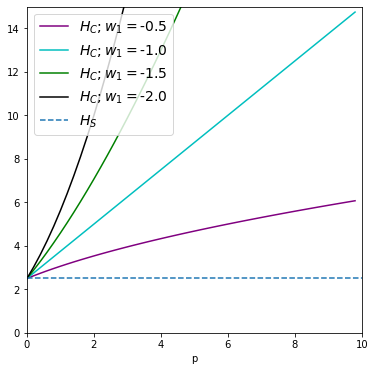

In [11]:
β = 1
w1vals = [-0.5, -1, -1.5, -2]


plim = 10
p = np.arange(0,plim,0.2)
plt.figure(figsize=(6,6))
colors = ['purple', 'c','g', 'k']
for i in range(0, len(w1vals)):
    w1 = w1vals[i]
    c = colors[i]
    fun_response_params = [1,λM, β, w1, λm, w2,0,0]
    #attackrate = attackrate_big_coop(x, p, fun_response_params)
    #y = typeI_fun_response(M, attackrate)
    y = fun_response_bigprey_cooperate(0,M,x,p,fun_response_params)
    plt.plot(p,y,color = c, label =r'$H_C; w_1 = $%.1f'%w1)

plt.axhline(functional_response(M, λM,1),linestyle='--', xmin = 0, xmax = plim, label = r'$H_S$')
plt.xlim([0,plim])
plt.ylim([0,15])

plt.xlabel('p')
plt.legend(fontsize = 14)
plt.gcf().savefig('funresponsesI.png')

# Type II functional Responses

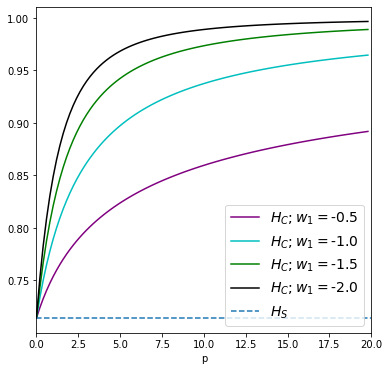

In [12]:
β = 1
w1vals = [-0.5, -1, -1.5, -2]


plim = 20
p = np.arange(0,plim,0.2)
plt.figure(figsize=(6,6))
colors = ['purple', 'c','g', 'k']
handlingtime = 1
for i in range(0, len(w1vals)):
    w1 = w1vals[i]
    c = colors[i]
    fun_response_params = [2, λM, β, w1, λm, w2, 0, 0]
    #attackrate = attackrate_big_coop(x, p, fun_response_params)
    y = y = fun_response_bigprey_cooperate(0,M,x,p,fun_response_params) #typeII_fun_response(M, attackrate, handlingtime)
    plt.plot(p,y,color = c, label =r'$H_C; w_1 = $%.1f'%w1)

plt.axhline(functional_response(M, λM,2),linestyle='--', xmin = 0, xmax = plim, label = r'$H_S$')
plt.xlim([0,plim])
#plt.ylim([0,1.5])

plt.xlabel('p')
plt.legend(fontsize = 14)
plt.gcf().savefig('funresponsesII.png')

In [54]:
r = 5; R = 4.5 # growth rate of small prey is double
q = 0.1; Q = 0.1 # predation depletion rates of preys
D = 4; # predator death rates
pop_params= [r,R,q,Q,D]

λM = 0.05; λm = 0.5
b = 0.1
B = 0.5

β = 1
w1 = -0.5; w2 = 2
fun_response_params = [1, λM, β, w1, λm, w2, B, b]


# initial point
m0 = 100
M0 = 50
x0 = 0.2
p0 = 20

In [55]:
average_fitness_predators(m0,M0,x0,p0,fun_response_params)

5.5990169943749475

In [56]:
pos = [m0,M0,x0,p0]
Δt = 0.01
args = [pop_params,fun_response_params]


In [57]:
for t in range(0,100):
    pos = rungeKutta(model, pos, Δt, args)

In [58]:
pos

array([2.40146124e+00, 5.29484342e-12, 6.92409938e-01, 1.96074720e+02])

In [59]:
t = np.arange(0,2,1)
out = odeint(model,[m0,M0,x0,p0],t,args=(pop_params, fun_response_params))

TypeError: model() takes 3 positional arguments but 4 were given

In [222]:
out

array([[ 1.00000000e+02,  5.00000000e+01,  2.00000000e-01,
         2.00000000e+01],
       [ 1.45509039e-09, -1.39572084e-11,  9.00170448e-01,
         4.82265955e+02]])

In [200]:
fun_dpdt(m0,M0,x0,p0,pop_params, fun_response_params)

142.3606797749979

In [207]:
out[0][1]

array([ 1.45509039e-09, -1.39572084e-11,  9.00170448e-01,  4.82265955e+02])

In [196]:
outarray = out[0]

In [195]:
7.12*20

142.4

In [197]:
m,M,x,p = outarray.T

In [198]:
p

array([ 2.00000000e+01,  4.82265955e+02,  1.77415733e+02,  6.52675988e+01,
        2.40106076e+01,  8.83300902e+00,  3.24948245e+00,  1.19541701e+00,
        4.39728261e-01,  1.59579459e-01,  7.87341921e-03, -5.75644177e-10,
        3.53716091e-12, -1.21054461e-11, -5.78777380e-11, -3.22142196e-13,
        1.30933421e-25,             nan,             nan,             nan])

In [184]:
p

array([ 2.00000000e+01,  4.82265955e+02,  1.77415733e+02,  6.52675988e+01,
        2.40106076e+01,  8.83300902e+00,  3.24948245e+00,  1.19541701e+00,
        4.39728261e-01,  1.59579459e-01,  7.87341921e-03, -5.75644177e-10,
        3.53716091e-12, -1.21054461e-11, -5.78777380e-11, -3.22142196e-13,
        1.30933421e-25,             nan,             nan,             nan])

In [185]:
β

1

In [188]:
λM/(β + 0.90017309*1.30933421e-25)**w1

0.05

In [132]:
p

array([ 20.        ,  22.10341836,  24.42805516,  26.99717615,
        29.83649395,  32.97442542,  36.44237601,  40.27505415,
        44.51081858,  49.19206224,  54.36563646,  60.08332012,
        66.40233782,  73.38593299,  81.10399889,  89.6337811 ,
        99.06065032, 109.47894936, 120.9929518 , 133.71789317])

In [140]:
x

array([2.00000000e-01, 2.84781828e+00, 1.56343484e+00, 8.58031343e-01,
       4.70897577e-01, 2.58434068e-01, 1.41831628e-01, 7.78388434e-02,
       4.27188672e-02, 2.34446086e-02, 1.28666842e-02, 7.06140036e-03,
       3.87538706e-03, 2.12686711e-03, 1.16723120e-03, 6.40574090e-04,
       3.51563457e-04, 1.92932422e-04, 1.05874768e-04, 5.80981311e-05])

In [146]:
b

0.1

In [144]:
inputs = m,M,x,p,fun_response_params
B,b = fun_response_params[-2:]
[*inputs]

[array([ 1.00000000e+02,  5.43712138e-02,  9.79217216e-06,  5.97838384e-10,
         6.00793964e-15, -1.50068198e-15,  6.24929057e-13, -3.66281077e-10,
         1.08421454e-10,  4.60456205e-11,  1.07172282e-09,  1.80722682e-08,
         7.50940397e-10,  2.08564247e-10, -1.38717597e-10,  1.56085655e-09,
         3.43259047e-11,  3.35609006e-11,  4.71234422e-09,  4.54522203e-10]),
 array([ 5.00000000e+01, -2.72100552e-10, -2.68923167e-10, -2.57141482e-11,
        -5.96119360e-09, -1.62389053e-09, -2.39214362e-09, -5.10663215e-10,
        -3.74051048e-10, -3.49726384e-10, -2.97139701e-10, -2.02169195e-10,
        -1.03581150e-10, -3.82924602e-11, -9.82893661e-12, -1.68386984e-12,
        -1.84339845e-13, -1.15656578e-14,  1.23765106e-16,  3.67266981e-17]),
 array([2.00000000e-01, 2.84781828e+00, 1.56343484e+00, 8.58031343e-01,
        4.70897577e-01, 2.58434068e-01, 1.41831628e-01, 7.78388434e-02,
        4.27188672e-02, 2.34446086e-02, 1.28666842e-02, 7.06140036e-03,
        3.87538706e-

In [136]:
average_fitness_predators(m, M, x, p, fun_response_params)

0.6

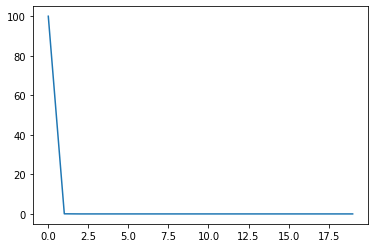

In [125]:
plt.plot(m)

In [115]:
typeII_fun_response(M, λM,1)

0.7142857142857143